In [1]:
#!/usr/bin/env python3.4

import os
import sys
import re
import cv2
import uuid
import random
import imageio
import numpy as np
import torch
import torch_scatter
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.transforms as T

# torch.multiprocessing.set_start_method(method='spawn', force=True)

os.environ["CUDA_VISIBLE_DEVICES"] = "6"
sys.path.append('../')

from scipy import misc
from PIL import Image
from tqdm import tqdm
from omegaconf import OmegaConf, DictConfig
from evaluation import eval_utils as eu

/tmp/ipykernel_73638/3657790019.py:22: DeprecationWarning: scipy.misc is deprecated and will be removed in 2.0.0
  from scipy import misc


In [2]:
def scale_time_equalization(video: torch.Tensor, sigma: float = 1.0, num_bins: int = 256) -> torch.Tensor:
    """
    Applies Scale-Time Equalization to a video tensor by first converting each frame
    to an illumination map (max RGB value per pixel), then temporally equalizing illumination,
    and finally rescaling the original RGB frames with the equalized illumination.

    Args:
        video (torch.Tensor): Input video of shape (N, 3, H, W) with pixel values in [0, 1] or [0, 255].
        sigma (float): Standard deviation for the temporal Gaussian smoothing (in frames).
        num_bins (int): Number of histogram bins (default: 256).

    Returns:
        torch.Tensor: Re-illuminated video of shape (N, 3, H, W).
    """
    N, C, H, W = video.shape
    device = video.device

    # Normalize to [0, 1] if needed
    if video.max() > 1.0:
        video = video / 255.0

    # Convert to illumination map: take max across RGB channels
    illum = video.max(dim=1, keepdim=True).values  # Shape: (N, 1, H, W)

    # 1. Compute per-frame histograms for illumination
    hist = torch.zeros((N, num_bins), device=device)
    for t in range(N):
        hist[t] = torch.histc(illum[t, 0], bins=num_bins, min=0.0, max=1.0)

    # 2. Create temporal Gaussian kernel
    kernel_size = int(6 * sigma) + 1
    if kernel_size % 2 == 0:
        kernel_size += 1
    half = kernel_size // 2
    time_axis = torch.arange(-half, half + 1, device=device, dtype=torch.float32)
    gauss_kernel = torch.exp(-0.5 * (time_axis / sigma) ** 2)
    gauss_kernel = gauss_kernel / gauss_kernel.sum()
    gauss_kernel = gauss_kernel.view(1, 1, -1)  # For conv1d

    # 3. Smooth histograms in time dimension
    h = hist.transpose(0, 1).unsqueeze(1)  # (num_bins, 1, N)
    h_padded = F.pad(h, (half, half), mode='reflect')
    h_smoothed = F.conv1d(h_padded, gauss_kernel)
    hist_smooth = h_smoothed.squeeze(1).transpose(0, 1)  # (N, num_bins)

    # 4. Compute CDFs
    cdf_orig = hist.cumsum(dim=-1)
    cdf_orig = cdf_orig / cdf_orig.max(dim=-1, keepdim=True).values
    cdf_smooth = hist_smooth.cumsum(dim=-1)
    cdf_smooth = cdf_smooth / cdf_smooth.max(dim=-1, keepdim=True).values

    # 5. Map each pixel using histogram specification per frame
    illum_eq = torch.empty_like(illum)
    bin_centers = torch.linspace(0.0, 1.0, steps=num_bins, device=device)

    for t in range(N):
        pixels = illum[t, 0].reshape(-1)
        idx = torch.searchsorted(cdf_orig[t], pixels)
        idx = idx.clamp(0, num_bins - 1)
        mapped = bin_centers[idx]
        illum_eq[t, 0] = mapped.view(H, W)

    # 6. Re-illuminate the original RGB frames
    reilluminated = video * (illum_eq / (illum + 1e-6))
    reilluminated = reilluminated.clamp(0, 1)

    return reilluminated

## 0. Data loading

In [4]:
output_dir = "../workdir/carla/iclight_vidtome/routes_town02_04_09_15_40_53_lmr_0.9_gmr_0.8_alpha_t_0.0"
config = OmegaConf.load(os.path.join(output_dir, 'config.yaml'))

if config.data.scene_type.lower() == "sceneflow":
    from utils.dataparsers import SceneFlowDataParser
    config.data.data_dir = os.path.join('../', config.data.data_dir)  # update relative path for notebook
    data_parser = SceneFlowDataParser(config.data, config.device, dtype=torch.float32)
    # data_parser.voxel_size, data_parser.use_raft = 0.01, False
    frame_ids = eu.get_frame_ids(config.generation.frame_range, config.generation.frame_ids)
    org_frames, _, _, flows, past_flows, mask_bwds =  data_parser.load_video(frame_ids)
elif config.data.scene_type.lower() == "carla":
    from utils.dataparsers import CarlaDataParser
    config.data.data_dir = os.path.join('../', config.data.data_dir)
    data_parser = CarlaDataParser(config.data, config.device, dtype=torch.float32)
    # data_parser.voxel_size, data_parser.use_raft = 0.01, False
    frame_ids = eu.get_frame_ids(config.generation.frame_range, config.generation.frame_ids)
    org_frames, _, _, flows, past_flows, mask_bwds =  data_parser.load_video(frame_ids)
elif config.data.scene_type.lower() == "video":
    from utils.dataparsers import VideoDataParser
    config.data.rgb_path = os.path.join('../', config.data.rgb_path).replace('agirobot', 'agibot')  # update relative path for notebook
    data_parser = VideoDataParser(config.data, config.device, dtype=torch.float32)
    frame_ids = eu.get_frame_ids(config.generation.frame_range, config.generation.frame_ids)
    org_frames, _, _, flows, past_flows, mask_bwds =  data_parser.load_video(frame_ids, rgb_threshold=2/255)
else:
    raise NotImplementedError(f"Scene type {config.data.scene_type} is not supported.")

[INFO] frame indexes:  0 1 ... 298 299


Loading Data: 100%|██████████| 417/417 [00:26<00:00, 15.48it/s]


[INFO] frame size (900, 1600) resize to (540, 960) and centercrop to (536, 960)
[INFO] frame size (900, 1600) resize to (540, 960) and centercrop to (536, 960)
[INFO] frame size (900, 1600) resize to (540, 960) and centercrop to (536, 960)
please consider installing flash attention for faster inference
MemFlowNet_skflow
no flash attention installed
[Using basicencoder as context encoder]
[Using basicencoder as feature encoder]
[Using GMA-SK2]
[Using corr_fn default]
[Loading ckpt from /data1/yang_liu/python_workspace/IC-Light/models/memflow/MemFlowNet_things.pth]
[INFO] Saving future flows to ../data/carla/sim2real_2_6/data_collect_town02_results/routes_town02_04_09_15_40_53/rgb_front/future_flow_memflow as .pt files
[INFO] Saving past flows to ../data/carla/sim2real_2_6/data_collect_town02_results/routes_town02_04_09_15_40_53/rgb_front/past_flow_memflow as .pt files
[INFO] Saving target flows to ../data/carla/sim2real_2_6/data_collect_town02_results/routes_town02_04_09_15_40_53/rgb_fr

Loading Flows:   0%|          | 0/300 [00:00<?, ?it/s]/data1/yang_liu/python_workspace/IC-Light/notebooks/../utils/dataparsers/video_dataparser.py:91: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this 

[INFO] frame size (536, 960) resize to (536, 960) and centercrop to (536, 960)
[INFO] frame size (536, 960) resize to (536, 960) and centercrop to (536, 960)


/data1/jing_li/anaconda3/envs/iclight-bkup/lib/python3.10/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Assigning flow ids: 100%|██████████| 299/299 [00:00<00:00, 830.55it/s]


[INFO] Scatter with Time Dimention.
Total number of unique voxels: 70527728 / 154368000


In [10]:
import clip
from torch_cluster import fps

model, preprocess = clip.load("ViT-B/32", device=data_parser.device)
model.eval()
with torch.no_grad():
    # transform to PIL image list
    images = []
    for i in range(len(org_frames)):
        image = Image.fromarray((org_frames[i].permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8))
        image = preprocess(image).unsqueeze(0).to(data_parser.device)
        images.append(image)
    image_features = model.encode_image(torch.cat(images))

custered_index = torch.sort(fps(image_features, ratio=0.25)).values
index_closest = custered_index[(torch.arange(len(image_features), device=image_features.device).unsqueeze(1) - \
                                custered_index.unsqueeze(0)).abs().argmin(dim=1)]
print(f"FPS index: {custered_index}")
print(f"Closest index: {index_closest}")

FPS index: tensor([  0,   4,   5,   6,   7,   8,   9,  11,  12,  14,  16,  19,  20,  23,
         57,  67,  76,  79,  81,  82,  83,  96, 110, 150, 151, 152, 153, 154,
        155, 156, 157, 158, 160, 161, 164, 166, 168, 169, 170, 171, 194, 210,
        212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225,
        227, 229, 230, 231, 232, 233, 240, 243, 245, 250, 251, 252, 254, 256,
        257, 258, 259, 260, 289], device='cuda:0')
Closest index: tensor([  0,   0,   0,   4,   4,   5,   6,   7,   8,   9,   9,  11,  12,  12,
         14,  14,  16,  16,  19,  19,  20,  20,  23,  23,  23,  23,  23,  23,
         23,  23,  23,  23,  23,  23,  23,  23,  23,  23,  23,  23,  23,  57,
         57,  57,  57,  57,  57,  57,  57,  57,  57,  57,  57,  57,  57,  57,
         57,  57,  57,  57,  57,  57,  57,  67,  67,  67,  67,  67,  67,  67,
         67,  67,  76,  76,  76,  76,  76,  76,  79,  79,  79,  81,  82,  83,
         83,  83,  83,  83,  83,  83,  96,  96,  96,  96,  96,  9

In [11]:
from utils.flow_utils import compute_fwdbwd_mask, get_key_mask_bwds
_, _, _, target_flows, src_flows, mask_bwds_st = data_parser.load_flow(frame_ids, gts=org_frames, target_ids=index_closest)

/data1/yang_liu/python_workspace/IC-Light/notebooks/../evaluation/eval_utils.py:238: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(cfg.restore_ckpt, map_lo

MemFlowNet_skflow
[Using basicencoder as context encoder]
[Using basicencoder as feature encoder]
[Using GMA-SK2]
[Using corr_fn default]
[Loading ckpt from /data1/yang_liu/python_workspace/IC-Light/models/memflow/MemFlowNet_things.pth]
[INFO] Saving future flows to ../data/carla/sim2real_2_6/data_collect_town02_results/routes_town02_04_09_15_40_53/rgb_front/future_flow_memflow as .pt files
[INFO] Saving past flows to ../data/carla/sim2real_2_6/data_collect_town02_results/routes_town02_04_09_15_40_53/rgb_front/past_flow_memflow as .pt files
[INFO] Saving target flows to ../data/carla/sim2real_2_6/data_collect_town02_results/routes_town02_04_09_15_40_53/rgb_front/target_flow_memflow as .pt files
[INFO] Saving src flows to ../data/carla/sim2real_2_6/data_collect_town02_results/routes_town02_04_09_15_40_53/rgb_front/src_flow_memflow as .pt files


Loading Flows:   0%|          | 0/300 [00:00<?, ?it/s]/data1/yang_liu/python_workspace/IC-Light/notebooks/../utils/dataparsers/video_dataparser.py:159: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this

[INFO] frame size (536, 960) resize to (536, 960) and centercrop to (536, 960)
[INFO] frame size (536, 960) resize to (536, 960) and centercrop to (536, 960)


## 2. Optimization

In [5]:
import datetime
from torch import nn
from torchvision.transforms.functional import rgb_to_grayscale
from plugin.VidToMe.utils import save_video
from utils.sh_utils import RGB2SH, SH2RGB, eval_sh
from utils.general_utils import get_expon_lr_func
from utils.loss_utils import l1_loss, l2_loss, depth_loss_dpt, VGGPerceptualLoss, TVLoss
from utils.dataloader import OptDataset
from utils.RIFE.IFNet_HDv4 import IFNet

# vgg_loss = VGGPerceptualLoss(resize=False)
max_sh_degree = 3
lambda_dssim = 0.2
lambda_perceptual = 0.01
lambda_depth = 1.0
lambda_flow = 0.8
lambda_tv = 0.05
lambda_key = 0.8
d_final_factor = 0.1

lambda_exp = 0.8
epochs_exposure = 35
epochs = 70
batch_size = 16
iterations = epochs_exposure * len(frame_ids) // batch_size

feature_lr = 0.05 * batch_size / len(frame_ids)
exposure_lr_init = 0.01
exposure_lr_final = 0.001
exposure_lr_delay_steps = 0
exposure_lr_delay_mult = 0.0

tv_loss = TVLoss(lambda_tv)
interpolater = IFNet(ckpt_path="../models/rife/flownet_v4.22.pkl").to(data_parser.device).eval()

/data1/yang_liu/python_workspace/IC-Light/notebooks/../utils/RIFE/IFNet_HDv4.py:128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(convert(torch.load(ck

In [6]:
pil_list = eu.video_to_pil_list(f'{output_dir}/output.mp4')
edited_images = torch.concat([eu.load_image(pil, flows.device, flows.dtype) for pil in pil_list], dim=0) / 255.0
N, _, H, W = edited_images.shape

dataset = OptDataset(
    edited_images,
    past_flows,
    mask_bwds,
    device=data_parser.device
)

data_loader = torch.utils.data.DataLoader(
    dataset, 
    batch_size=batch_size, 
    shuffle=True
)

del edited_images, pil_list, mask_bwds, flows, past_flows

In [7]:
SHOW_INTEGRATION_RESULTS = False
if SHOW_INTEGRATION_RESULTS:
    with torch.no_grad():
        pil_list = eu.video_to_pil_list(f'{output_dir}/output_gt.gif')
        org_images = torch.concat([eu.load_image(pil, config.device) for pil in pil_list], dim=0) / 255.0
        
        pil_tensor = dataset.edited_images.permute(0, 2, 3, 1).reshape(N*H*W, -1)
        pil_tensor = torch_scatter.scatter(pil_tensor, data_parser.unq_inv, dim=0, reduce='mean')
        print(f"Total number of unique voxels: {pil_tensor.shape[0]} / {N * H * W}")

        images = pil_tensor[data_parser.unq_inv].reshape(N, H*W, -1) # N x HW x 3
        images = torch.clamp(images, 0, 1).reshape(N, H, W, 3).permute(0, 3, 1, 2)  # N x 3 x H x W

        images_np = images.permute(0, 2, 3, 1).detach().cpu().numpy()
        edited_images_np = dataset.edited_images.permute(0, 2, 3, 1).cpu().numpy()
        org_images_np = org_images.permute(0, 2, 3, 1).cpu().numpy()

    plt.style.use("seaborn-v0_8-whitegrid")
    idx = random.randint(0, N-1)
    idx = 70
    plt.figure(figsize=(16, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(images_np[idx])
    plt.title(f"Rendered RGB of Frame {idx}")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(org_images_np[idx])
    plt.title(f"Edited of Frame {idx}")
    plt.axis("off")

In [8]:
from utils.flow_utils import warp_flow
from utils.loss_utils import l1_loss, relaxed_ms_ssim

torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()
start_time = datetime.datetime.now()

loss_list_exposure = []
pbar = tqdm(total=epochs_exposure, desc="Optimizing Exposures")

exposure = nn.Parameter(torch.eye(3, 4, device="cuda")[None].repeat(len(frame_ids), 1, 1).requires_grad_(True))
exposure_optimizer = torch.optim.Adam([exposure])
exposure_scheduler_args = get_expon_lr_func(exposure_lr_init, exposure_lr_final,
                                            lr_delay_steps=exposure_lr_delay_steps,
                                            lr_delay_mult=exposure_lr_delay_mult,
                                            max_steps=iterations)

for epoch in range(epochs_exposure):
    for i, (idxs, _edited_images, _pre_edited_images, _past_flows, _mask_bwds) in enumerate(data_loader):

        iteration = epoch * len(frame_ids) // batch_size + i + 1
        for param_group in exposure_optimizer.param_groups:
            param_group['lr'] = exposure_scheduler_args(iteration)

        cat_images = torch.cat([_edited_images, _pre_edited_images], dim=0)
        cat_idxs = torch.cat([idxs, idxs-1], dim=0)
        cat_idxs[cat_idxs < 0] = 0

        cat_images = torch.bmm(cat_images.permute(0, 2, 3, 1).reshape(-1, H*W, 3), exposure[cat_idxs, :3, :3]) + exposure[cat_idxs, None, :3, 3]
        cat_images = torch.clamp(cat_images, 0, 1).reshape(-1, H, W, 3).permute(0, 3, 1, 2)  # N x 3 x H x W

        images = cat_images[:len(idxs)]
        pre_images = cat_images[len(idxs):]

        loss_photometric = l1_loss(images, _edited_images) * (1 - lambda_dssim) + \
                            (1.0 - relaxed_ms_ssim(images, _edited_images, data_range=1, start_level=1)) * lambda_dssim

        warped_images = warp_flow(pre_images, _past_flows)[idxs>0]
        images, _mask_bwds = images[idxs>0], _mask_bwds[idxs>0]

        loss_flow = l1_loss(warped_images * _mask_bwds, images * _mask_bwds)

        loss = (1 - lambda_exp) * loss_photometric + lambda_exp * loss_flow

        loss_list_exposure.append(loss.item())

        loss.backward()

        exposure_optimizer.step()
        exposure_optimizer.zero_grad(set_to_none = True)
    
    pbar.set_postfix(
        loss='{:3f}'.format(loss.item()), 
        loss_flow='{:3f}'.format(loss_flow.item()),
        loss_photometric='{:3f}'.format(loss_photometric.item())
    )
    pbar.update()

pbar.close()

dataset.exposure_align(exposure)

end_time = datetime.datetime.now()
max_memory_allocated = torch.cuda.max_memory_allocated() / (1024.0 ** 2)
print(f"Memory: {max_memory_allocated:.2f} MB")
print(f"Time: {(end_time - start_time).total_seconds()}s")

Optimizing Exposures: 100%|██████████| 35/35 [00:39<00:00,  1.13s/it, loss=0.024612, loss_flow=0.028121, loss_photometric=0.010575]

Memory: 10540.27 MB
Time: 39.72715s


In [10]:
ANALYZE_SSIM = False
if ANALYZE_SSIM:
    with torch.no_grad():
        pil_tensor = dataset.edited_images.permute(0, 2, 3, 1).reshape(N*H*W, -1)
        pil_tensor = torch_scatter.scatter(pil_tensor, data_parser.unq_inv, dim=0, reduce='mean')

    images = pil_tensor[data_parser.unq_inv].reshape(N, H*W, -1) # N x HW x 3
    images = torch.clamp(images, 0, 1).reshape(N, H, W, 3).permute(0, 3, 1, 2)  # N x 3 x H x W

    # idx = random.randint(0, N-1)
    idx = 244
    ssim = relaxed_ms_ssim(images[idx:idx+1], dataset.edited_images[idx:idx+1], data_range=1, start_level=4)
    print(f"SSIM of Frame {idx}: {ssim.item()}")

    # win = _fspecial_gauss_1d(11, 1.5)
    # win = win.repeat([images.shape[1]] + [1] * (len(images.shape) - 1))
    # ssim_map, cs_map = _relaxed_ssim(images[idx:idx+1], dataset.edited_images[idx:idx+1], win=win, data_range=1, flatten=False)
    # l_map = ssim_map / cs_map

    # show distribution of per-channel SSIM
    # plt.style.use("seaborn-v0_8-whitegrid")
    # plt.hist(l_map[0, 0].reshape(-1).cpu().numpy(), bins=100, color='r', alpha=0.5, label='R');
    # plt.hist(l_map[0, 1].reshape(-1).cpu().numpy(), bins=100, color='g', alpha=0.5, label='G');
    # plt.hist(l_map[0, 2].reshape(-1).cpu().numpy(), bins=100, color='b', alpha=0.5, label='B');

    plt.style.use("seaborn-v0_8-whitegrid")
    plt.figure(figsize=(16, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(images[idx].permute(1, 2, 0).cpu().numpy())
    plt.title(f"Rendered RGB of Frame {idx}")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(dataset.edited_images[idx].permute(1, 2, 0).cpu().numpy())
    # plt.imshow(l_map[0].permute(1, 2, 0).cpu().numpy())
    plt.title(f"Edited of Frame {idx}")
    plt.axis("off")

In [11]:
# smooth_iteration = 20
# smoothed_edited_images = dataset.edited_images

# for k in tqdm(range(smooth_iteration), desc="Frames Smoothing"):
#     edited_images = [smoothed_edited_images[0]]
#     for i in range(1, N-1):
#         s_frame = smoothed_edited_images[i-1:i]
#         m_frame = smoothed_edited_images[i:i+1]
#         e_frame = smoothed_edited_images[i+1:i+2]

#         with torch.no_grad():
#             interp_frames_s = interpolater.inference(s_frame, m_frame)
#             interp_frames_e = interpolater.inference(m_frame, e_frame)
#             interp_frames_m = interpolater.inference(interp_frames_s, interp_frames_e)

#         edited_images.append(interp_frames_m[0])
#     edited_images.append(smoothed_edited_images[-1])
#     smoothed_edited_images = torch.stack(edited_images, dim=0)

# dataset.edited_images = smoothed_edited_images

# save_name = f"rife_smoothed_{smooth_iteration}"
# cur_output_path = os.path.join(output_dir, save_name)
# save_video(smoothed_edited_images, cur_output_path, save_frame=True, fps=15, gif=False)
# # copy output_dir/config.yaml and output_dir/output_gt.gif to cur_output_path
# os.system(f"cp {os.path.join(output_dir, 'config.yaml')} {cur_output_path}")
# os.system(f"cp {os.path.join(output_dir, 'output_gt.gif')} {cur_output_path}")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Idx: 252, Closest Idx: 252


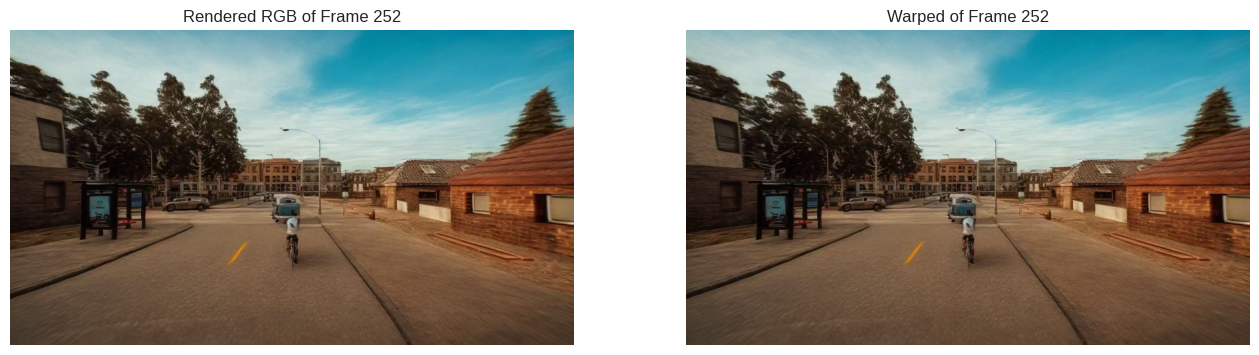

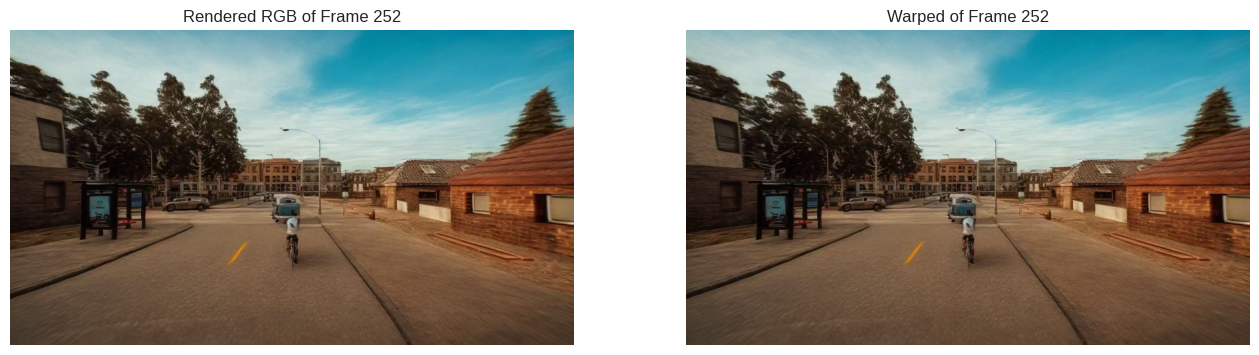

In [70]:
ANALYZE_FLOW_MASK = True
if ANALYZE_FLOW_MASK:
    from utils.flow_utils import warp_flow, get_mask_bwds

    # mask_bwds = get_mask_bwds(org_frames, flows, past_flows, alpha=1.0, diff_threshold=0.1)
    mask_bwds_st = get_key_mask_bwds(org_frames, index_closest, target_flows, src_flows, alpha=0.75, diff_threshold=0.1)
    idx = random.randint(1, len(dataset.edited_images)-1)
    # idx = 22

    # image, pre_image = org_frames[idx:idx+1], org_frames[idx-1:idx]
    # past_flow = past_flows[idx:idx+1]
    # warped_image = warp_flow(pre_image, past_flow)
    # warped_image_m = warped_image * mask_bwds[idx:idx+1].float()
    # image_m = image * mask_bwds[idx:idx+1].float()

    print(f"Idx: {idx}, Closest Idx: {index_closest[idx]}")
    src_image, image = dataset.edited_images[idx:idx+1], dataset.edited_images[index_closest[idx]:index_closest[idx]+1]
    warped_image = warp_flow(src_image, src_flows[idx:idx+1])
    warped_image_m = warped_image * mask_bwds_st[idx:idx+1].float()
    image_m = image * mask_bwds_st[idx:idx+1].float()

    plt.style.use("seaborn-v0_8-whitegrid")
    plt.figure(figsize=(16, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(image[0].permute(1, 2, 0).detach().cpu().numpy())
    plt.title(f"Rendered RGB of Frame {idx}")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(warped_image[0].permute(1, 2, 0).detach().cpu().numpy())
    plt.title(f"Warped of Frame {idx}")
    plt.axis("off")

    plt.figure(figsize=(16, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(image_m[0].permute(1, 2, 0).detach().cpu().numpy())
    plt.title(f"Rendered RGB of Frame {idx}")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(warped_image_m[0].permute(1, 2, 0).detach().cpu().numpy())
    plt.title(f"Warped of Frame {idx}")
    plt.axis("off")

In [69]:
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()
start_time = datetime.datetime.now()
pbar.close()

with torch.no_grad():
    pil_tensor = dataset.edited_images.permute(0, 2, 3, 1).reshape(N*H*W, -1)
    pil_tensor = torch_scatter.scatter(pil_tensor, data_parser.unq_inv, dim=0, reduce='mean')

    # prepare per-image confidence weights
    # loss_weight = relaxed_ms_ssim(org_frames, dataset.edited_images, data_range=1, start_level=1, size_average=False)
    # loss_weight = loss_weight / loss_weight.sum() * len(loss_weight)  # normalize to sum to N

fused_color = RGB2SH(pil_tensor)
features_dc = nn.Parameter(fused_color.contiguous().requires_grad_(True))

# check if each index in data_parser.unq_inv is unique
cnt = torch.unique(data_parser.unq_inv, return_counts=True)[1]
nonunique_mask = (cnt > 1)[data_parser.unq_inv]

feature_residuals = nn.Parameter(torch.zeros_like(features_dc[data_parser.unq_inv][nonunique_mask]).contiguous().requires_grad_(True))

l = [
    {'params': [features_dc], 'lr': feature_lr, "name": "f_dc"},
    {'params': [feature_residuals], 'lr': feature_lr, "name": "f_residuals"},
]
optimizer = torch.optim.Adam(l, lr=0.0, eps=1e-15)

loss_list = []

pbar = tqdm(total=epochs, desc="Optimizing Unique Tensor")

for epoch in range(epochs):
    for i, (idxs, _edited_images, _, _past_flows, _mask_bwds) in enumerate(data_loader):

        step = epoch * len(frame_ids) // batch_size + i + 1
        _mask_bwds = _mask_bwds[idxs>0]
        cat_idxs = torch.cat([idxs, idxs-1], dim=0)
        cat_idxs[cat_idxs < 0] = 0

        unq_inv = data_parser.unq_inv.reshape(N, H, W, -1)[cat_idxs].reshape(-1)
        cat_images = SH2RGB(features_dc)[unq_inv].reshape(len(cat_idxs), H*W, -1) # N x HW x 3
        residuals = torch.zeros_like(features_dc[data_parser.unq_inv])
        residuals[nonunique_mask] = feature_residuals
        residuals = residuals.reshape(N, H, W, -1)[cat_idxs].reshape(len(cat_idxs), H*W, -1)
        cat_images = cat_images + residuals
        # cat_images = SH2RGB(features_dc).reshape(N, H, W, -1)[cat_idxs]
        cat_images = torch.clamp(cat_images, 0, 1).reshape(len(cat_idxs), H, W, 3).permute(0, 3, 1, 2)  # N x 3 x H x W

        images = cat_images[:len(idxs)]
        pre_images = cat_images[len(idxs):]

        warped_images = warp_flow(pre_images, _past_flows)
        warped_images_m = warped_images[idxs>0]
        images_m = images[idxs>0]
        warped_images_m = warped_images_m * _mask_bwds.float()
        images_m = images_m * _mask_bwds.float()

        # warped_images_key = warp_flow(images, src_flows[idxs])
        # warped_images_key_m = warped_images_key * mask_bwds_st[idxs].float()
        # key_images = dataset.edited_images[index_closest[idxs]] * mask_bwds_st[idxs].float()

        # plt.style.use("seaborn-v0_8-whitegrid")
        # plt.figure(figsize=(16, 10))
        # plt.subplot(1, 2, 1)
        # plt.imshow(images_m[0].permute(1, 2, 0).detach().cpu().numpy())
        # plt.title(f"Rendered RGB of Frame {idxs[0]}")
        # plt.axis("off")

        # plt.subplot(1, 2, 2)
        # plt.imshow(_edited_images[0].permute(1, 2, 0).detach().cpu().numpy())
        # plt.title(f"Warped of Frame {idxs[0]}")
        # plt.axis("off")
        # break
        
        loss_flow = l1_loss(images_m, warped_images_m)
        # loss_flow = (1.0 - relaxed_ms_ssim(images_m, warped_images_m, data_range=1, start_level=1)) * lambda_dssim + \
        #             l1_loss(images_m, warped_images_m) * (1 - lambda_dssim)
        
        # 0. original
        loss_photometric = (1.0 - relaxed_ms_ssim(images, _edited_images, data_range=1, start_level=1)) * lambda_dssim


        # 1. quantize images to relax the restriction
        # loss_ssim = (1.0 - ms_ssim(images, _edited_images, data_range=1)) * lambda_dssim
        # loss_ssim_org = (1.0 - ms_ssim(rgb_to_grayscale(images), rgb_to_grayscale(org_images[idxs]), data_range=1)) * lambda_dssim * 0.2
        # loss_photometric = loss_ssim + loss_ssim_org

        # 2. weight the ssim loss with per-image confidence
        # loss_photometric = ((1.0 - relaxed_ms_ssim(images, _edited_images, data_range=1, 
        #                     start_level=1, size_average=False)) * loss_weight[idxs]).mean() * lambda_dssim

        # 3. weight the ssim loss with per-pixel confidence
        # loss_ssim = (1.0 - weighted_ms_ssim(images, _edited_images, org_frames[idxs], data_range=1, start_level=1)) * lambda_dssim
        
        # 4. use perceptual loss as supervision
        # loss_photometric = vgg_loss(images, _edited_images) * lambda_perceptual

        # 5. use depth estimation as supervision
        # depth_weight = get_weight(step, iterations, lambda_depth, d_final_factor)
        # depths = depth_anything(transform(images))
        # depths = F.interpolate(depths[:, None], (H, W), mode="bilinear", align_corners=True).squeeze()
        # loss_photometric = depth_loss_dpt(depths[:, None], depths_org[idxs], ssim_loss_func) * depth_weight

        # 6. use TV loss as regularization
        loss_tv = tv_loss(images)

        loss = (1 - lambda_flow) * loss_photometric + lambda_flow * loss_flow + loss_tv

        loss_list.append([loss.item(), loss_photometric.item(), loss_flow.item()])

        loss.backward()

        optimizer.step()
        optimizer.zero_grad(set_to_none = True)

    pbar.set_postfix(
        loss='{:3f}'.format(loss.item()), 
        loss_flow='{:3f}'.format(loss_flow.item()),
        loss_photometric='{:3f}'.format(loss_photometric.item())
    )
    pbar.update()
    
pbar.close()

end_time = datetime.datetime.now()
max_memory_allocated = torch.cuda.max_memory_allocated() / (1024.0 ** 2)
print(f"Memory: {max_memory_allocated:.2f} MB")
print(f"Time: {(end_time - start_time).total_seconds()}s")

images = SH2RGB(features_dc)[data_parser.unq_inv]
images[nonunique_mask] = images[nonunique_mask] + feature_residuals
images = images.reshape(N, H*W, -1)

# images = SH2RGB(features_dc)[data_parser.unq_inv].reshape(N, H*W, -1) # N x HW x 3
# images = SH2RGB(features_dc).reshape(N, H*W, -1) # N x HW x 3
images = torch.clamp(images, 0, 1).reshape(N, H, W, 3).permute(0, 3, 1, 2)  # N x 3 x H x W

Optimizing Unique Tensor: 100%|██████████| 70/70 [02:23<00:00,  2.05s/it, loss=0.006088, loss_flow=0.006007, loss_photometric=0.005688]

Memory: 28317.08 MB
Time: 143.369718s


: 

Text(0.5, 1.0, 'Loss curve for unique tensor optimization')

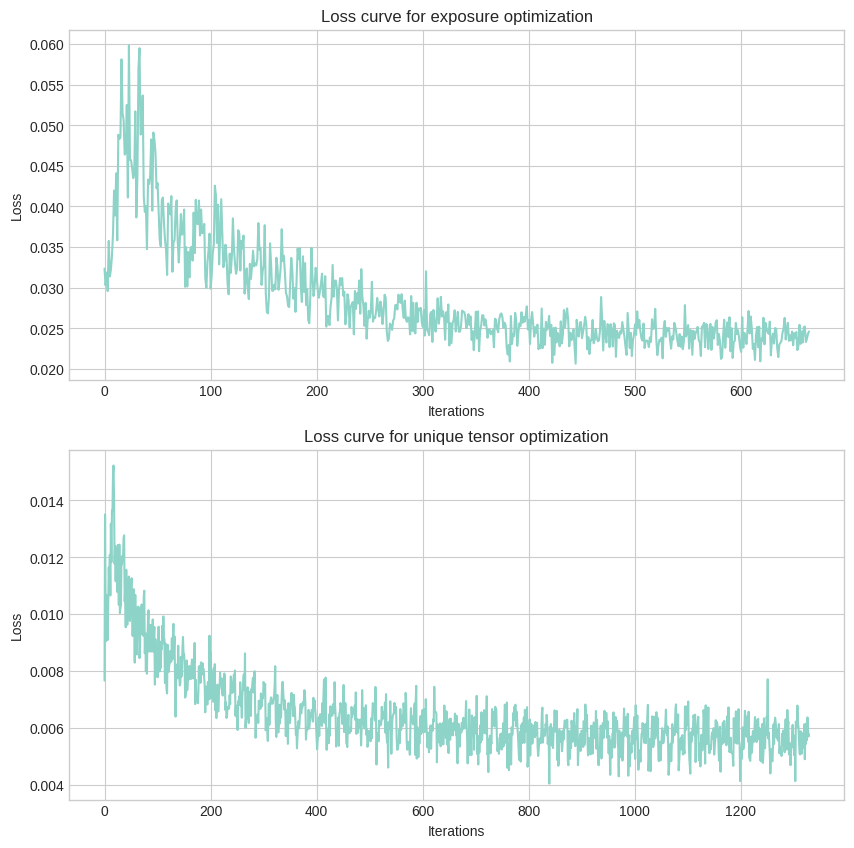

In [23]:
plt.style.use("seaborn-v0_8-whitegrid")
plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(loss_list_exposure)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Loss curve for exposure optimization")

plt.subplot(2, 1, 2)
plt.plot(np.array(loss_list)[:, 0])
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Loss curve for unique tensor optimization")

In [124]:
# save_name = f"opt_lr_{feature_lr:3f}_lambda_flow_{lambda_flow}_lambda_exp_{lambda_exp}_ssim_{lambda_dssim}_slevel1_ep{epochs}_loss_{loss_list[-1]:.3f}"
save_name = f"opt_lr_{feature_lr:3f}_lambda_flow_{lambda_flow}_lambda_exp_{lambda_exp}_lambda_key_{lambda_key}_loss_{loss_list[-1][0]:.3f}"
cur_output_path = os.path.join(output_dir, save_name)
save_video(images, cur_output_path, save_frame=True, fps=15, gif=False)
# copy output_dir/config.yaml and output_dir/output_gt.gif to cur_output_path
os.system(f"cp {os.path.join(output_dir, 'config.yaml')} {cur_output_path}")
os.system(f"cp {os.path.join(output_dir, 'output_gt.mp4')} {cur_output_path}")

[INFO] save video to ../workdir/carla/iclight_vidtome/routes_town02_04_09_15_40_53_lmr_0.9_gmr_0.8_alpha_t_0.0/opt_lr_0.002667_lambda_flow_0.8_lambda_exp_0.8_lambda_key_0.8_loss_0.002/output.mp4


0

In [26]:
images_np = images.permute(0, 2, 3, 1).detach().cpu().numpy()
edited_images_np = dataset.edited_images.permute(0, 2, 3, 1).cpu().numpy()
# smoothed_edited_images_np = smoothed_edited_images.permute(0, 2, 3, 1).cpu().numpy()
# org_images_np = org_frames.permute(0, 2, 3, 1).cpu().numpy()

(-0.5, 959.5, 535.5, -0.5)

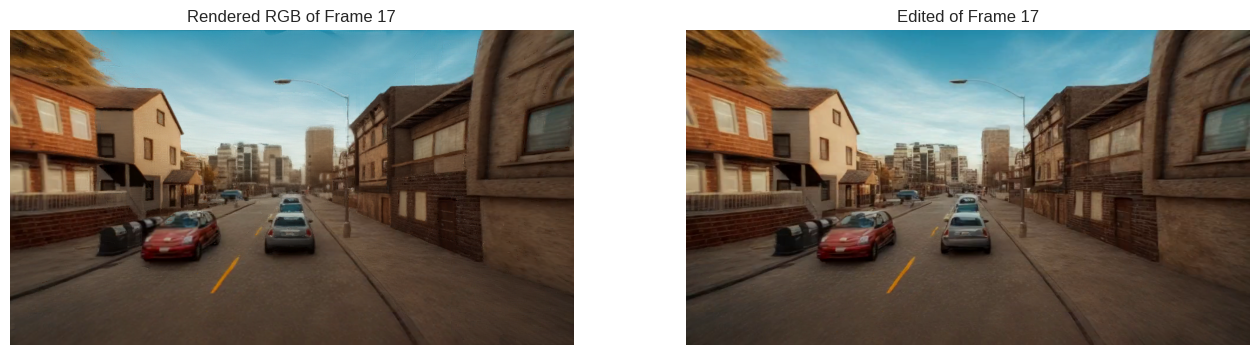

In [68]:
plt.style.use("seaborn-v0_8-whitegrid")
idx = random.randint(0, N-1)
# idx = 188

# with torch.no_grad():
#     mask_bwd = dataset.mask_bwd[idx:idx+1]
#     warped_images = warp_flow(images[idx-1:idx], dataset.past_flows[idx:idx+1])
#     warped_images[~mask_bwd] = 0
#     warped_images = warped_images.permute(0, 2, 3, 1).cpu().numpy()
#     warped_images = np.clip(warped_images[0], 0, 1)

plt.figure(figsize=(16, 10))
plt.subplot(1, 2, 1)
plt.imshow(images_np[idx])
plt.title(f"Rendered RGB of Frame {idx}")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(edited_images_np[idx])
plt.title(f"Edited of Frame {idx}")
# plt.imshow(warped_images)
# plt.title(f"Warped of Frame {idx}")
plt.axis("off")